- [ ] **Date**: Create *Year* and *Month* columns from *Date*. Drop the *Date* column.
- [ ] **Year**: Compute mean of *Fuel_Price* by year and impute with the year the *Fuel_price* is the closest to the mean
- [ ] **Month**: Compute mean of *Tempurature* by month and impute with the month the *Tempurature* is the closest to the mean
- [ ] **Store**: Nothing.
- [ ] **Temperature**: Impute missing values with the mean of the temprature of the observation month
- [ ] **Fuel_Price**: Impute missing values with the mean between the closest inferior and superior date
- [ ] **CPI**: Imputing the missing data by the mean between the closest before and after date of the store
- [ ] **Unemployment**: Impute with the median
- [ ] **Weekly_Sales**: Drop missing values

## Part 2 & 3 : Preprocessing and model

This notebook is divided in 4 sections :
- Preprocessing with Pandas
- Preprocessing witn Scikitlearn
- Baseline model
- Regularisation

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score

In [2]:
# Import data
data_before_imputation = pd.read_csv('Walmart_Store_sales.csv')
# Just working on a copy of the dataset to later compare basic statistics between both datasets
data = data_before_imputation.copy()
data_before_imputation.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


### 1. Preprocessing in Pandas 
In this section, we will preprocess the data impute the missing data based on the work done during the EDA in the first notebook

#### 1.1 Date

- [x] Create *Year* and *Month* columns from *Date*. Drop the *Date* column.
- [x] Compute mean of *Fuel_Price* by year and impute with the year the *Fuel_price* is the closest to the mean
- [x] Compute mean of *Tempurature* by month and impute with the month the *Temperature* is the closest to the mean

In [3]:
# Cast Date to Datetime type
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Extract Year and Month
data['Year'] = data['Date'].dt.year.astype('Int64')
data['Month'] = data['Date'].dt.month.astype('Int64')

# Drop Date column
data.drop(columns=['Date'], axis=0, inplace=True)

data.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3
2,17.0,NaN,0.0,NaN,NaN,130.719581,5.936,2012,7
3,11.0,1244390.03,0.0,84.57,NaN,214.556497,7.346,<NA>,<NA>
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5


In [4]:
## YEAR
# Calculate the average fuel price per year
avg_fuelprice_year = data.groupby(by='Year').mean()['Fuel_Price']
avg_fuelprice_year

Year
2010    2.791915
2011    3.553780
2012    3.729000
Name: Fuel_Price, dtype: float64

In [6]:
mask = data['Year'].isnull() & data['Fuel_Price'].notnull()
data[mask].head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month
9,3.0,418925.47,0.0,60.12,3.555,224.132020,6.833,<NA>,<NA>
17,18.0,1205307.50,0.0,21.33,2.788,131.527903,9.202,<NA>,<NA>
34,2.0,1853161.99,0.0,87.70,3.480,214.929625,NaN,<NA>,<NA>
42,1.0,1661767.33,1.0,NaN,3.730,222.439015,6.908,<NA>,<NA>
65,10.0,1714309.90,NaN,43.43,3.287,127.191774,8.744,<NA>,<NA>


In [9]:
# Substract the avg_fuelprice_year by the fuel price of the row, here 3.555
avg_fuelprice_year.sub(3.555)

Year
2010   -0.763085
2011   -0.001220
2012    0.174000
Name: Fuel_Price, dtype: float64

In [10]:
# equivalent to:
avg_fuelprice_year - 3.555

Year
2010   -0.763085
2011   -0.001220
2012    0.174000
Name: Fuel_Price, dtype: float64

In [12]:
# Take the absolute value
avg_fuelprice_year.sub(3.555).abs()

Year
2010    0.763085
2011    0.001220
2012    0.174000
Name: Fuel_Price, dtype: float64

In [13]:
# Find the index with the smallest value
avg_fuelprice_year.sub(3.555).abs().idxmin()

2011

In [8]:
avg_fuelprice_year.sub(2.788).abs().idxmin()

2010

In [7]:
# Add the year the average fuel price is the closest to the observation fuel price
mask = data['Year'].isnull() & data['Fuel_Price'].notnull()
data.loc[mask, 'Year'] = data.loc[mask, 'Fuel_Price'].apply(lambda x :avg_fuelprice_year.sub(x).abs().idxmin())

# Fill the remaining missing values with the most frequent value in the dataset (only one row will be affected)
data['Year'].fillna(data['Year'].mode().iloc[0], inplace=True)

In [9]:
## MONTH
# Calculate the average temperature by month
avg_temperature_month = data.groupby(by='Month').mean()['Temperature']
avg_temperature_month

Month
1     43.946667
2     39.904545
3     47.935455
4     53.723333
5     63.460000
6     76.079231
7     79.721538
8     79.536000
9     73.710000
10    62.631111
11    61.255714
12    38.804444
Name: Temperature, dtype: float64

In [10]:
# Add the month the average temperature is the closest to the observation temperature
mask = data['Month'].isnull() & data['Temperature'].notnull()
data.loc[mask, 'Month'] = data.loc[mask, 'Temperature'].apply(lambda x :avg_temperature_month.sub(x).abs().idxmin())

# Fill the remaining missing values with the most frequent value in the dataset (4 will be affected)
data['Month'].fillna(data['Month'].mode().iloc[0], inplace=True)

#### 1.2 Store
- [x] Cast the Store id to Int

In [15]:
#### STORE
data['Store'] = data['Store'].astype('Int64')

#### 1.3 Temperature
- [x] Impute missing values with the mean of the temprature of the observation month

In [16]:
## Temperature
# Fill with the average temperature of the observation month
mask = data['Temperature'].isnull()
data.loc[mask, 'Temperature'] = data.loc[mask, 'Month'].apply(lambda x : round(avg_temperature_month[x],2))

#### 1.4 Fuel
- [x] Impute missing values with the average fuel price of the year

In [18]:
## Fuel price
mask = data['Fuel_Price'].isnull()
data.loc[mask, 'Fuel_Price'] = data.loc[mask, 'Year'].apply(lambda x : round(avg_fuelprice_year[x],3))

#### 1.5 CPI
- [x] Impute missing values with the mean CPI of the store

In [21]:
## CPI
# Calculate the average CPI per Store
avg_cpi_store = data.groupby(by='Store').mean()['CPI']
avg_cpi_store

Store
1     216.368313
2     214.769437
3     220.115306
4     128.196148
5     216.905432
6     215.902088
7     195.319489
8     216.373831
9     215.001735
10    128.162431
11    217.844972
12    128.060487
13    129.041653
14    185.325833
15    134.987597
16    194.473622
17    128.331461
18    134.888911
19    135.319093
20    209.187937
Name: CPI, dtype: float64

In [22]:
mask = data['CPI'].isnull()
data.loc[mask, 'CPI'] = data.loc[mask, 'Store'].apply(lambda x : avg_cpi_store[x])

#### 1.6 Unemployment
- [x] Impute missing values with the median

In [25]:
## Uemployment
data['Unemployment'].fillna(data['Unemployment'].median(), inplace=True)

#### 1.7 Holiday flag
- [x] Impute missing values with 0

In [26]:
##  Holiday Flag
data['Holiday_Flag'] = data['Holiday_Flag'].astype('Int64')
data['Holiday_Flag'].fillna(0, inplace=True)

#### 1.8 Weekly sales
- [x] Drop observations with null values

In [27]:
## Weekly Sales
data.dropna(subset=['Weekly_Sales'], inplace=True)

#### 1.9 Sanity check
Just checking that there are no missing values left and that the preprocessing did not affect too much the basics stattistics of our dataset

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 0 to 149
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         136 non-null    Int64  
 1   Weekly_Sales  136 non-null    float64
 2   Holiday_Flag  136 non-null    Int64  
 3   Temperature   136 non-null    float64
 4   Fuel_Price    136 non-null    float64
 5   CPI           136 non-null    float64
 6   Unemployment  136 non-null    float64
 7   Year          136 non-null    Int64  
 8   Month         136 non-null    Int64  
dtypes: Int64(4), float64(5)
memory usage: 11.2 KB


In [29]:
data_before_imputation.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
mean,9.866667,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000
max,20.000000,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000


In [30]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month
count,136.000000,1.360000e+02,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,10.014706,1.249536e+06,0.066176,61.764559,3.302544,178.449559,7.645449,2010.860294,6.463235
std,6.124614,6.474630e+05,0.249509,18.066654,0.477706,39.800240,1.534320,0.818063,3.150328
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000,2010.000000,1.000000
25%,4.000000,6.050757e+05,0.000000,47.252500,2.804000,131.806597,6.833000,2010.000000,4.000000
50%,10.000000,1.261424e+06,0.000000,63.460000,3.390500,194.849563,7.470000,2011.000000,6.500000
75%,15.250000,1.806386e+06,0.000000,76.660000,3.723750,214.809008,8.100750,2012.000000,9.000000
max,20.000000,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000,2012.000000,12.000000


### 2. Preprocessing with Scikitlearn 
In this section, we will continue the preprocessing using Scikitlearn :
- [x] Split dataset between features and target
- [x] Split dataset in train et test sets
- [x] Standardize the numerical features
- [x] Do a OneHotEncoding on the categorical features

In [65]:
# Separate target variable y from features X
X = data.loc[:,data.columns != 'Weekly_Sales']
X.head()

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month
0,6,0,59.61,3.045,214.777523,6.858,2011,2
1,13,0,42.38,3.435,128.616064,7.470,2011,3
3,11,0,84.57,2.792,214.556497,7.346,2010,7
4,6,0,78.89,2.759,212.412888,7.092,2010,5
5,4,0,63.46,2.756,126.160226,7.896,2010,5


In [66]:
y = data.loc[:, data.columns == 'Weekly_Sales']
y.head()            

,Weekly_Sales
0,1572117.54
1,1807545.43
3,1244390.03
4,1644470.66
5,1857533.70


In [67]:
# Divide dataset Train set & Test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [68]:
#### Data proprocessing
# List the indices for categorical and numerical features
categorical_indices = [0,1]
numeric_indices=[2,3,4,5,6,7]

## Prepare transformers
# Normalization
numeric_transformer = StandardScaler()

# OHE / dummyfication
categorical_transformer = OneHotEncoder(drop='first', sparse=False)

## Combine the transformers into a single object
featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

## Apply the transformaters
# Fit and transform on X_train
X_train = featureencoder.fit_transform(X_train)

# Transform on X_test
X_test = featureencoder.transform(X_test)

### 3. Baseline model
Let's train a simple linear regression and see how our model perfom.

In [69]:
# Train the model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [70]:
print(f'The score on the train set is {regressor.score(X_train, y_train)}')
print(f'The score on the train set is {regressor.score(X_test, y_test)}')

The score on the train set is 0.9701625127332628
The score on the train set is 0.9298261156695665


Our score is pretty good. However the model seems to overfit as the score on the train set is superior to the test set.
When we look at the feature importance, we can see that what impacts the more our model is the **Store** and the **CPI**

In [71]:
# Recreate the list of features seen by the model
ohe_cat = featureencoder.named_transformers_['cat'].categories_
store_features = ['Store_' + str(element) for element in ohe_cat[0][1:]]
holiday_flag_features = ['Holiday_' + str(element) for element in ohe_cat[1][1:]]
num_features = list(featureencoder.named_transformers_['num'].feature_names_in_)
features = store_features + holiday_flag_features + num_features

coeff = pd.DataFrame({'Feature' : store_features + holiday_flag_features + num_features, 'Coeff' : np.around(regressor.coef_[0],2)})
coeff.sort_values(by='Coeff', key=abs, ascending=False)

,Feature,Coeff
3,Store_5,-1339196.99
1,Store_3,-1203599.04
2,Store_4,1176496.98
8,Store_10,1085368.28
11,Store_13,1076524.25
7,Store_9,-1071755.45
14,Store_16,-949526.25
5,Store_7,-928076.26
6,Store_8,-764933.50
12,Store_14,753928.72


<AxesSubplot:xlabel='Coeff', ylabel='Feature'>

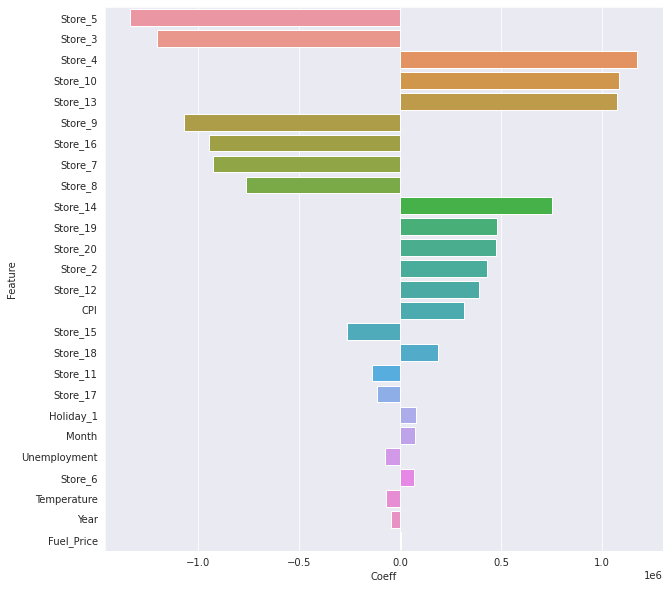

In [72]:
plt.figure(figsize=(10, 10))
sns.barplot(y="Feature", x="Coeff",  data=coeff.sort_values(by='Coeff', key=abs, ascending=False))

### 3. Regularization
In this section, we will try to fight the overfitting by using the Ridge and Lasso models and see which on perform best on our model.

#### 3.1 Ridge

In [73]:
ridge_regressor = Ridge()

# Grid of values to be tested
params = {
    'alpha': [0.0, 0.025,  0.05, 0.075, 0.1] # 0 corresponds to no regularization
}

gridsearch_ridge = GridSearchCV(ridge_regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch_ridge.fit(X_train, y_train)

print("Best hyperparameters : ", gridsearch_ridge.best_params_)
print("Best R2 score : ", gridsearch_ridge.best_score_)

Best hyperparameters :  {'alpha': 0.075}
Best R2 score :  0.9360243287399067


In [74]:
y_train_pred_ridge = gridsearch_ridge.predict(X_train)
y_test_pred_ridge = gridsearch_ridge.predict(X_test)

print("R2 score on training set : ", r2_score(y_train, y_train_pred_ridge))
print("R2 score on test set : ", r2_score(y_test, y_test_pred_ridge))

R2 score on training set :  0.9692939213219883
R2 score on test set :  0.9297099266383906


#### 3.2 Lasso

In [75]:
params = {'alpha' : [550, 575,600,625,650]}
lasso_regressor = Lasso(max_iter = 10000)
gridsearch_lasso = GridSearchCV(lasso_regressor,param_grid = params, cv=3)

gridsearch_lasso.fit(X_train,y_train)

print("Best hyperparameters : ", gridsearch_lasso.best_params_)
print("Best R2 score : ", gridsearch_lasso.best_score_)

Best hyperparameters :  {'alpha': 650}
Best R2 score :  0.938348346719749


In [76]:
y_train_pred_lasso = gridsearch_lasso.predict(X_train)
y_test_pred_lasso = gridsearch_lasso.predict(X_test)

print("R2 score on training set : ", r2_score(y_train, y_train_pred_lasso))
print("R2 score on test set : ", r2_score(y_test, y_test_pred_lasso))

R2 score on training set :  0.9692041603936895
R2 score on test set :  0.936721411832944


#### 3.2 Conclusion
The Lasso regularization with **alpha = 650** helps reducizing the overfitting of our model. We barely lost any accuracy on our train set and increase  the accuracy on the test set by